# Frame Normalized PCA example

The Erebus pipeline uses Principal Component Analysis (PCA) on the normalized time-series frames of an exoplanet eclipse observation, in order to remove the effects of astrophysical sources and be left only with pixel-level systematic effects (see Connors et al 2025). Principal component analysis is a dimensionality reduction technique: read more on [Wikipedia](https://en.wikipedia.org/wiki/Principal_component_analysis).

There are many custom exoplanet eclipse reduction pipelines, and rather than requiring you use the entire Erebus pipeline you can simply use it's FN-PCA functionality in your own code.

### Loading fits data with Erebus (skip if you have your own file loading implementation)

First we will extract a 3D array of the time-series frames captured by JWST. For this we will use Erebus, which offers the `WrappedFits` object to load the frames and time information from a JWST pipeline `calints.fits` file, and the `fits_file_utils` script that includes helper methods for parsing `.fits` data.

The WrappedFits file also performs outlier and nan removal as described in Connors et al 2025.

In [7]:
from erebus.utility.fits_file_utils import get_fits_files_visits_in_folder

folder = "../../manual_tests/mast_lhs1478b"
visits = get_fits_files_visits_in_folder(folder)

print(f"In the folder {folder} there are {len(visits)} visits: {visits}")

In the folder ../../manual_tests/mast_lhs1478b there are 2 visits: ['jw03730012001' 'jw03730013001']


In [9]:
from erebus.wrapped_fits import WrappedFits

fits = WrappedFits(folder, visits[0])

### Performing FN-PCA

Using either the frames contained in the Erebus WrappedFits object or from your own implementation, we can now perform FN-PCA. This method takes a 3D array of the time-series observations, as well as an aperture radius, annulus start, and annulus end (in pixels) to perform background subtraction with before normalizing the values within the aperture.

In [23]:
from erebus.frame_normalized_pca import perform_fnpca_on_full_frame

# Using a radius of 5 pixels and an annulus spanning 10 to 20 pixels
eigenvalues, eigenvectors, variance_ratio = perform_fnpca_on_full_frame(fits.frames, 5, 10, 20)

# For a given principal component, the each number in the eigenvalues corresponds to a time
time = fits.t

This method returns three arrays, where each index corresponds to a principal component. 

Each principal component has an eigenvalue/eigenvector pair, and a variance ratio indictating how much of the total variance in the time series is caused by that component. The eigenvalues can be used for modelling systematic trends (i.e., a systematic model made of a linear combination of the top 5 highest variance components). The eigenvectors are useful in identifying the nature of the systematic effect represented by the principal component.

Below is an example of visualizing the eigenvalue/eigenvector pairs from this visit of LHS1478b

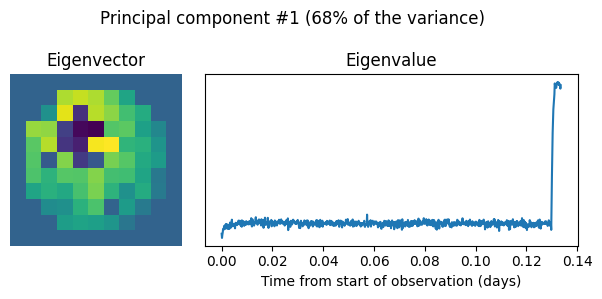

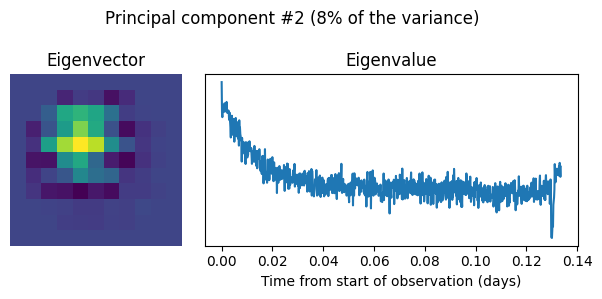

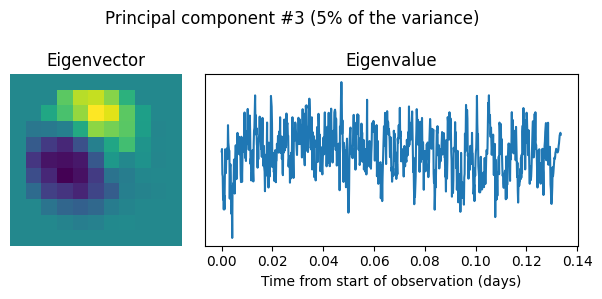

In [44]:
import matplotlib.pyplot as plt
import numpy as np

def plot_principal_component(eigenvalues, eigenvectors, variance_ratio, time, index):
	fig = plt.figure(figsize=(6, 3)) 
	gs = fig.add_gridspec(1, 3)
	
	ax1 = fig.add_subplot(gs[0, 0])
	ax2 = fig.add_subplot(gs[0, 1:])
	
	ax1.imshow(eigenvectors[index])
	ax1.set_title(f"Eigenvector")
	ax1.axis('off')
	
	ax2.plot(time - np.min(time), eigenvalues[index])
	ax2.set_title("Eigenvalue")
	ax2.set_xlabel("Time from start of observation (days)")
	ax2.yaxis.set_visible(False)

	plt.suptitle(f"Principal component #{index+1} ({(variance_ratio[index]*100):.0f}% of the variance)")
	
	plt.tight_layout()
	plt.show()

plot_principal_component(eigenvalues, eigenvectors, variance_ratio, time, 0)
plot_principal_component(eigenvalues, eigenvectors, variance_ratio, time, 1)
plot_principal_component(eigenvalues, eigenvectors, variance_ratio, time, 2)

We see a huge source of error occuring near the end of the observation: We can trim this from the data and repeat the FN-PCA

In [45]:
from erebus.frame_normalized_pca import perform_fnpca_on_full_frame

trimmed_eigenvalues, trimmed_eigenvectors, trimmed_variance_ratio = perform_fnpca_on_full_frame(fits.frames[:-40], 5, 10, 20)
trimmed_time = fits.t[:-40]

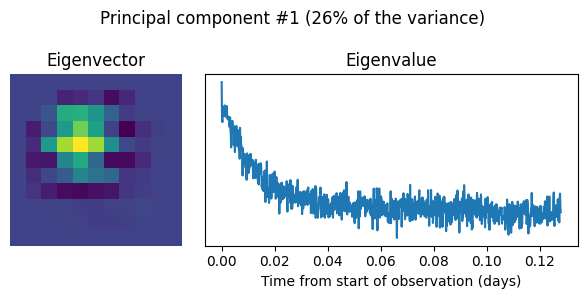

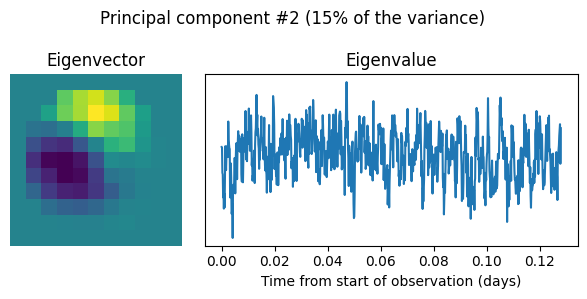

In [46]:
plot_principal_component(trimmed_eigenvalues, trimmed_eigenvectors, trimmed_variance_ratio, trimmed_time, 0)
plot_principal_component(trimmed_eigenvalues, trimmed_eigenvectors, trimmed_variance_ratio, trimmed_time, 1)

With principal component analysis it is also useful to compare the variance ratios of each component, which results in an elbow shaped plot:

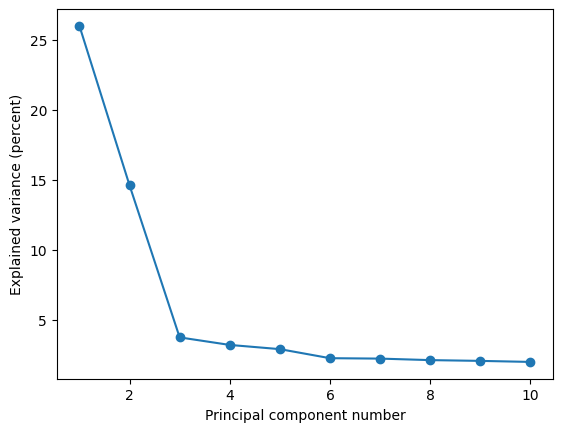

In [63]:
plt.plot(np.arange(1, 11), trimmed_variance_ratio[:10] * 100, marker='o')
plt.ylabel("Explained variance (percent)")
plt.xlabel("Principal component number")
plt.show()